In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

from tqdm import tqdm

# model
import lightgbm as lgb

SEED=42
LABEL=None

In [0]:
path = '/content/drive/My Drive/bigcontest2019/'
os.chdir(path)

In [0]:
train_activity = pd.read_csv('data/train/train_activity.csv')
train_combat = pd.read_csv('data/train/train_combat.csv')
train_payment = pd.read_csv('data/train/train_payment.csv')
train_pledge = pd.read_csv('data/train/train_pledge.csv')
train_trade = pd.read_csv('data/train/train_trade.csv')

test1_activity = pd.read_csv('data/test/test1_activity.csv')
test1_combat = pd.read_csv('data/test/test1_combat.csv')
test1_payment = pd.read_csv('data/test/test1_payment.csv')
test1_pledge = pd.read_csv('data/test/test1_pledge.csv')
test1_trade = pd.read_csv('data/test/test1_trade.csv')

test2_activity = pd.read_csv(path + 'data/test/test2_activity.csv')
test2_combat = pd.read_csv(path + 'data/test/test2_combat.csv')
test2_payment = pd.read_csv(path + 'data/test/test2_payment.csv')
test2_pledge = pd.read_csv(path + 'data/test/test2_pledge.csv')
test2_trade = pd.read_csv(path + 'data/test/test2_trade.csv')

train_label = pd.read_csv('data/train/train_label.csv')

In [0]:
class data_transform(object):
    def __init__(self, data):
        self.data = data
        
    def create_week(self):
        self.data['week'] = (self.data['day']-1)//7 + 1
        return self.data
    
    def activity_transform(self):
        temp_df = self.data
        groupby_dict = defaultdict()
        
        temp_df = pd.get_dummies(temp_df)
        
        for feature in temp_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day' or feature == 'char_id':
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = 'sum'
        
        
        temp_df = temp_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
        
        return temp_df
    
    def payment_transform(self):
        output_df = self.data
        
        output_df['amount_spent'] = np.round(output_df['amount_spent'], 5)
        output_df['adjust_amount_spent'] = output_df['amount_spent'].apply(lambda x: 1 if x>0 else 0)
        
        output_df = output_df.groupby(['acc_id', 'week'])['adjust_amount_spent'].size().reset_index()
        output_df['adjust_amount_spent'] = 1
        
        return output_df
    
    def trade_transform(self):
        output_df = self.data
    
        trade_agg = {'day':'nunique', 
                       'type':'nunique', 
                       'server':'nunique', 
                       'source_char_id':'nunique',
                       'target_acc_id':'nunique', 
                       'target_char_id':'nunique',
                       'item_type':'nunique', 
                       'item_amount':'sum', 
                       'item_price':'sum'}
        merge_df1 = output_df.groupby(['source_acc_id', 'week']).agg(trade_agg).reset_index()
        
        trade_agg = {'day':'nunique', 
                       'type':'nunique', 
                       'server':'nunique', 
                       'source_acc_id':'nunique', 
                       'source_char_id':'nunique',
                       'target_char_id':'nunique',
                       'item_type':'nunique', 
                       'item_amount':'sum', 
                       'item_price':'sum'}
        merge_df2 = output_df.groupby(['target_acc_id', 'week']).agg(trade_agg).reset_index()
        
        return merge_df1, merge_df2
    
    
    def under_sampling(self):
        temp_df = self.data
        output_df = pd.DataFrame()
        for week in [1, 2, 3, 4]:
            _, under_sample = train_test_split(temp_df[(temp_df['week']==week) & (temp_df['survival_time']==64)], test_size=0.001, random_state=42, shuffle=True, 
                                               stratify=temp_df.loc[(temp_df['week']==week) & (temp_df['survival_time']==64), 'day'])
            output_df = pd.concat([output_df, under_sample]).reset_index(drop=True)
        
        return output_df
    
    def under_sampling2(self):
        temp_df = self.data
        _, under_sample = train_test_split(temp_df[(temp_df['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True)
#                                            stratify=temp_df.loc[(temp_df['survival_time']==64), 'daynunique'])
        
        return under_sample

# survival time

## train

### acitivity

In [0]:
transform = data_transform(train_activity)
transform.create_week()
transform_act = transform.activity_transform()

### payment

In [0]:
transform = data_transform(train_payment)
transform.create_week()
transform_pay = transform.payment_transform()

### trade

In [0]:
trandform = data_transform(train_trade)
trandform.create_week()
transform_trade1, transform_trade2 = trandform.trade_transform()

### merge

In [0]:
train = pd.merge(transform_act, transform_pay, how='left', on=['acc_id', 'week'])
train = pd.merge(train, transform_trade1.rename(columns={'source_acc_id':'acc_id'}), how='left', on=['acc_id', 'week'])
train = pd.merge(train, transform_trade2.rename(columns={'target_acc_id':'acc_id'}), how='left', on=['acc_id', 'week'])

## test

### activity

In [0]:
transform = data_transform(test1_activity)
transform.create_week()
transform_act1 = transform.activity_transform()

transform = data_transform(test2_activity)
transform.create_week()
transform_act2 = transform.activity_transform()

### payment

In [0]:
transform = data_transform(test1_payment)
transform.create_week()
transform_pay1 = transform.payment_transform()

transform = data_transform(test2_payment)
transform.create_week()
transform_pay2 = transform.payment_transform()

### trade

In [0]:
trandform = data_transform(test1_trade)
trandform.create_week()
transform_trade11, transform_trade12 = trandform.trade_transform()

trandform = data_transform(test2_trade)
trandform.create_week()
transform_trade21, transform_trade22 = trandform.trade_transform()

### merge

In [0]:
test1 = pd.merge(transform_act1, transform_pay1, how='left', on=['acc_id', 'week'])
test1 = pd.merge(test1, transform_trade11.rename(columns={'source_acc_id':'acc_id'}), how='left', on=['acc_id', 'week'])
test1 = pd.merge(test1, transform_trade12.rename(columns={'target_acc_id':'acc_id'}), how='left', on=['acc_id', 'week'])

test2 = pd.merge(transform_act2, transform_pay2, how='left', on=['acc_id', 'week'])
test2 = pd.merge(test2, transform_trade21.rename(columns={'source_acc_id':'acc_id'}), how='left', on=['acc_id', 'week'])
test2 = pd.merge(test2, transform_trade22.rename(columns={'target_acc_id':'acc_id'}), how='left', on=['acc_id', 'week'])

In [0]:
train.shape, test1.shape, test2.shape

((149226, 76), (71235, 72), (70734, 78))

In [0]:
train.fillna(0,inplace=True)
test1.fillna(0,inplace=True)
test2.fillna(0,inplace=True)

## model

In [0]:
# # model
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import KFold
# from sklearn.linear_model import Ridge 

# import xgboost as xgb
# import warnings

# class model(object):
#     def __init__(self, train, test, label, folds=FOLDS, seed=SEED):
#         self.train = train
#         self.test = test
#         self.kf = KFold(n_splits=folds, random_state=seed)
#         self.skf = StratifiedKFold(n_splits=folds,random_state=seed)
#         self.label = label
    
#     def ridge_model(self):
#         oof_spent = np.zeros(len(self.train))
#         pred_spent = np.zeros(len(self.test))

#         oof_time = np.zeros(len(self.train))
#         pred_time = np.zeros(len(self.test))
        
#         for trn_idx, val_idx in self.kf.split(self.train):
#             train_df = self.train.loc[trn_idx]
#             valid_df = self.train.loc[val_idx].drop(['amount_spent','survival_time'], axis=1)
         
#             spent_ridge_model = Ridge().fit(train_df.drop(['amount_spent','survival_time'], axis=1), train_df['amount_spent'])
#             time_ridge_model = Ridge().fit(train_df.drop(['amount_spent','survival_time'], axis=1), train_df['survival_time'])
            
#             oof_spent[val_idx] = spent_ridge_model.predict(valid_df)
#             oof_time[val_idx] = time_ridge_model.predict(valid_df)

#             pred_spent += spent_ridge_model.predict(self.test)/self.kf.n_splits
#             pred_time += time_ridge_model.predict(self.test)/self.kf.n_splits

#         return oof_time, oof_spent, pred_time, pred_spent
    
#     def rf_model(self):
#         oof_spent = np.zeros(len(self.train))
#         pred_spent = np.zeros(len(self.test))

#         oof_time = np.zeros(len(self.train))
#         pred_time = np.zeros(len(self.test))

#         for trn_idx, val_idx in self.kf.split(self.train):
#             train_df = self.train.loc[trn_idx]
#             valid_df = self.train.loc[val_idx]
#             label_df = self.label[trn_idx]

#             if self.log:
#                 spent_rf = RandomForestRegressor().fit(X=train_df, y=np.log1p(label_df['spent_time']))
#                 time_rf = RandomForestRegressor().fit(X=train_df, axis=1), y=np.log1p(label_df['survival_time']))

#             else:
#                 spent_rf = RandomForestRegressor().fit(X= train_df, axis=1), y = label_df['amount_spent'])
#                 time_rf = RandomForestRegressor().fit(X= train_df, axis=1), y = label_df['survival_time'])

#             oof_spent[val_idx] = spent_rf.predict(valid_df)
#             oof_time[val_idx] = time_rf.predict(valid_df)

#             pred_spent += spent_rf.predict(self.test)/self.kf.n_splits
#             pred_time += time_rf.predict(self.test)/self.kf.n_splits
#         return oof_time, oof_spent, pred_time, pred_spent
        
#     def xgb_model(self):
#         warnings.filterwarnings(action='ignore')
        
        
            
#         oof_spent = np.zeros(len(self.train))
#         pred_spent = np.zeros(len(self.test))

#         oof_time = np.zeros(len(self.train))
#         pred_time = np.zeros(len(self.test))

#         for trn_idx, val_idx in self.kf.split(self.train):

#             else:
#                 spent_valid_df = xgb.DMatrix(self.train.loc[val_idx].drop(['amount_spent','survival_time'], axis=1), label=np.log1p(self.train.loc[trn_idx, 'amount_spent' ]))

#                 spent_train_df = xgb.DMatrix(self.train.loc[trn_idx].drop(['amount_spent','survival_time'], axis=1), label=self.train.loc[trn_idx, 'amount_spent' ])
#                 time_train_df = xgb.DMatrix(self.train.loc[trn_idx].drop(['amount_spent','survival_time'], axis=1), label=self.train.loc[val_idx,'survival_time' ])
                
#                 spent_valid_df = xgb.DMatrix(self.train.loc[val_idx].drop(['amount_spent','survival_time'], axis=1), label=self.train.loc[trn_idx, 'amount_spent' ])
#                 time_valid_df = xgb.DMatrix(self.train.loc[val_idx].drop(['amount_spent','survival_time'], axis=1), label=self.train.loc[val_idx,'survival_time' ])

#                 time_train_df = xgb.DMatrix(self.train.loc[trn_idx], label=np.log1p(self.train.loc[val_idx,'survival_time' ]))
#                 time_valid_df = xgb.DMatrix(self.train.loc[val_idx].drop(['amount_spent','survival_time'], axis=1), label=np.log1p(self.train.loc[val_idx,'survival_time' ]))


#             spent_xgb_model = xgb.train(params, spent_train_df, num_boost_round=5000, evals=[(spent_train_df, 'train'), (spent_valid_df, 'val')], verbose_eval=100, early_stopping_rounds=10)
#             time_xgb_model = xgb.train(params, time_train_df, num_boost_round=5000, evals=[(time_train_df, 'train'), (time_valid_df, 'val')], verbose_eval=100, early_stopping_rounds=10)
            
#             oof_spent[val_idx] = spent_xgb_model.predict(xgb.DMatrix(self.train.loc[val_idx].drop(['amount_spent','survival_time'], axis=1)))
#             oof_time[val_idx] = time_xgb_model.predict(xgb.DMatrix(self.train.loc[val_idx].drop(['amount_spent','survival_time'], axis=1)))

#             pred_spent += spent_xgb_model.predict(xgb.DMatrix(self.test))/self.kf.n_splits
#             pred_time += time_xgb_model.predict(xgb.DMatrix(self.test))/self.kf.n_splits

#         return oof_time, oof_spent, pred_time, pred_spent
    
#     def rmse(self, true, pred):
        
#         if self.log:
#             true = np.expm1(pred)
#             mse = mean_squared_error(true, pred)
#             rmse = np.round(np.sqrt(mse), 2)
#         else:
#             mse = mean_squared_error(true, pred)
#             rmse = np.round(np.sqrt(mse), 2)
    
#         return rmse

#     def lgb_model(self):
        
#         params = {
#             'objective':'regression',
#             "boosting": "gbdt",
#             "num_iterations ":100,
#             'num_leaves': 10000,
#             'max_depth': 8,
#             'learning_rate': 0.1,
#             'min_data_in_leaf': 32, 
#             'min_child_samples': 30,
#             'min_child_weight': 0.5,
#             'min_split_gain': 0.005,
#             "feature_fraction": 0.9,
#             "bagging_fraction": 0.9 ,
#             "bagging_freq": 2,
#             "bagging_seed": 42,
#             "metric": 'rmse',
#             "lambda_l1": 0.1,
#             "lambda_l2": 0.1
#         }
                
#         oof_time = np.zeros(len(self.train))
#         oof_spent = np.zeros(len(self.train))
#         pred_time = np.zeros(len(self.test))
#         pred_spent = np.zeros(len(self.test))
        
#         for trn_idx, val_idx in self.kf.split(train):
            
#             train_df = lgb.Dataset(self.train.loc[trn_idx].drop(['amount_spent','survival_time'], axis=1), label=self.train.loc[trn_idx, 'amount_spent'])
#             valid_df = lgb.Dataset(self.train.loc[val_idx].drop(['amount_spent','survival_time'], axis=1), label=self.train.loc[val_idx, 'amount_spent'])
            
#             lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
#             oof_spent[val_idx] = lgb_model.predict(self.train.loc[val_idx])/self.skf.n_splits
#             pred_spent += lgb_model.predict(self.test)/self.kf.n_splits
        
#         # params = {
#         #     'objective':'multiclass',
#         #     'num_class':65,
#         #     "boosting": "gbdt",
#         #     "num_iterations ":100,
#         #     'num_leaves': 10000,
#         #     'max_depth': 8,
#         #     'learning_rate': 0.1,
#         #     'min_data_in_leaf': 32, 
#         #     'min_child_samples': 30,
#         #     'min_child_weight': 0.5,
#         #     'min_split_gain': 0.005,
#         #     "feature_fraction": 0.9,
#         #     "bagging_fraction": 0.9 ,
#         #     "bagging_freq": 2,
#         #     "bagging_seed": 42,
#         #     "metric": 'multi_logloss',
#         #     "lambda_l1": 0.1,
#         #     "lambda_l2": 0.1
#         # }

#         for trn_idx, val_idx in self.skf.split(self.train, self.train['survival_time']):
            
#             train_df = lgb.Dataset(self.train.loc[trn_idx].drop(['amount_spent','survival_time'], axis=1), label=self.train.loc[trn_idx, 'survival_time'])
#             valid_df = lgb.Dataset(self.train.loc[val_idx].drop(['amount_spent','survival_time'], axis=1), label=self.train.loc[val_idx, 'survival_time'])
            
#             lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
#             oof_time[val_idx] = lgb_model.predict(self.train.loc[val_idx])/self.skf.n_splits
#             pred_time += lgb_model.predict(self.test)/self.skf.n_splits
        
#         return oof_time, oof_spent, pred_time, pred_spent

In [0]:
class model(object):
    def __init__(self, train_data, train_label, test1_data, test2_data):
        self.train_data = train_data
        self.train_label = train_label
        self.test1_data = test1_data
        self.test2_data = test2_data
        
    def labeling(self):
        self.train_data = pd.merge(self.train_data, self.train_label[['acc_id', 'survival_time']], how='left', on='acc_id')
        for week in range(1, 5):
            self.train_data.loc[train['week']==week, 'survival_time'] = np.minimum(64, self.train_data.loc[self.train_data['week']==week, 'survival_time'] + 7*(4-week))
        
    def under_sampling(self):
        all_week_under_sample = pd.DataFrame()
        for week in range(1, 5):
            _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True, 
                                               stratify=self.train_data.loc[(self.train_data['week']==week) & (self.train_data['survival_time']==64), 'day'])
            all_week_under_sample = pd.concat([all_week_under_sample, under_sample]).reset_index(drop=True)
        else:
            self.train_data = pd.concat([self.train_data[self.train_data['survival_time']!=64], all_week_under_sample]).reset_index(drop=True)
            
    def st_lgb_model(self, params, seed):
        LABEL='survival_time'
        for train_df, valid_df in train_test_split(self.train_data, test_size=0.2, random_state=seed, shuffle=True, stratify=self.train_data[LABEL]):

        
        feature_ = self.test1_data.drop(columns=['acc_id', 'week']).columns

        trn_label = train_df[LABEL] - 1
        val_label = valid_df[LABEL] - 1
        ttt = lgb.Dataset(train_df[feature_], label=trn_label)
        vvv = lgb.Dataset(valid_df[feature_], label=val_label)

        lgb_model = lgb.train(params, ttt, 5000, valid_sets = [ttt, vvv], early_stopping_rounds = 50, verbose_eval=100)
        self.st_lgb_model = lgb_model
        
        preds_st = lgb_model.predict(self.test1_data[feature_].fillna(0))
        preds_st = np.argmax(preds_st, axis=1)+1

#         preds_st2 = lgb_model.predict(test2[feature_].fillna(0))
#         preds_st2 = np.argmax(preds_st2, axis=1)+1
        
        return preds_st
    
    def feature_importance(self):
        feature_imp = pd.DataFrame(sorted(zip(self.st_lgb_model.feature_importance(), self.test1_data.drop(columns=['acc_id', 'week']).columns)), columns=['Value','Feature'])
        plt.figure(figsize=(20, 10))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.show()

In [0]:
PARAMS = {
    'objective':'multiclass',
    'num_class':64,
    "boosting": "gbdt",
    'learning_rate': 0.03,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 16,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'seed':SEED
}

model_ = model(train, train_label, test1, pd.DataFrame())
model_.labeling()
model_.under_sampling()
preds_st = model_.st_lgb_model(PARAMS, SEED)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 3.20301	valid_1's multi_logloss: 3.56594
[200]	training's multi_logloss: 2.83559	valid_1's multi_logloss: 3.46541
[300]	training's multi_logloss: 2.57046	valid_1's multi_logloss: 3.42404
[400]	training's multi_logloss: 2.35951	valid_1's multi_logloss: 3.40633
[500]	training's multi_logloss: 2.18276	valid_1's multi_logloss: 3.39883
[600]	training's multi_logloss: 2.02957	valid_1's multi_logloss: 3.39651
Early stopping, best iteration is:
[629]	training's multi_logloss: 1.98904	valid_1's multi_logloss: 3.39605


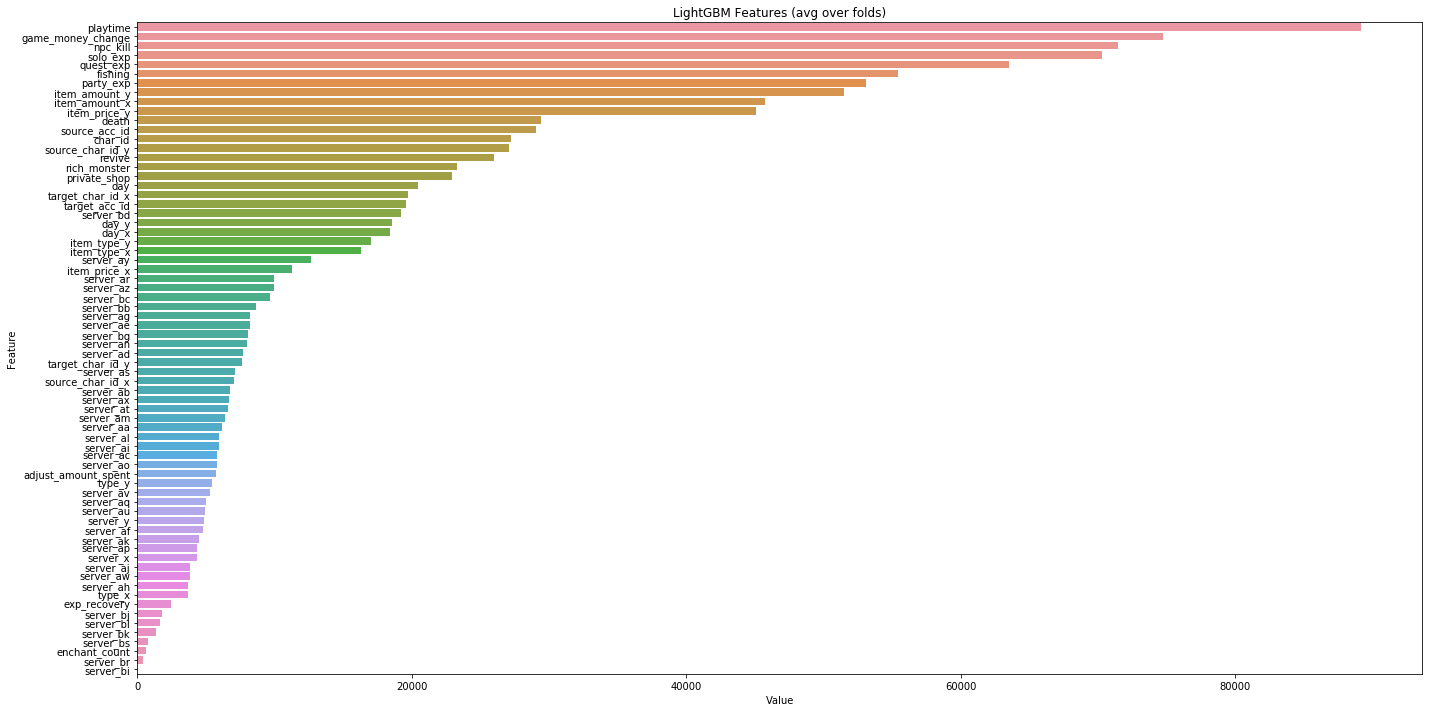

In [0]:
model_.feature_importance()

In [0]:
test2['server_b

In [0]:
test2.drop(['server_bq','server_be','server_bh','server_bf'],axis=1,inplace=True)

In [0]:
model_ = model(train, train_label, test2, pd.DataFrame())
model_.labeling()
model_.under_sampling()
preds_st2 = model_.st_lgb_model(PARAMS, SEED)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 3.21862	valid_1's multi_logloss: 3.5786
[200]	training's multi_logloss: 2.85075	valid_1's multi_logloss: 3.47647
[300]	training's multi_logloss: 2.58593	valid_1's multi_logloss: 3.4346
[400]	training's multi_logloss: 2.37523	valid_1's multi_logloss: 3.41677
[500]	training's multi_logloss: 2.19799	valid_1's multi_logloss: 3.40857
[600]	training's multi_logloss: 2.04573	valid_1's multi_logloss: 3.4056
Early stopping, best iteration is:
[649]	training's multi_logloss: 1.97753	valid_1's multi_logloss: 3.40537


# amount spent

In [0]:
# train_label['amount_spent'] = np.round(train_label['amount_spent'], 5)

In [0]:
train_label

,acc_id,survival_time,amount_spent,amount_spent_round
0,27835,64,0.002559,0.00
1,12351,64,0.120154,0.12
2,125437,55,0.182593,0.18
3,104483,64,0.016241,0.02
4,4704,20,0.226396,0.23
5,3277,50,0.058863,0.06
6,118874,64,0.030777,0.03
7,7678,5,0.000000,0.00
8,124997,46,0.009187,0.01
9,116489,23,0.000000,0.00


In [0]:
train_label['amount_spent_round'] = np.round(train_label['amount_spent'], 2)
stack_df = pd.DataFrame()
idx_lst =[]

for as_round in train_label['amount_spent_round'].unique():
    temp_df = train_label[train_label['amount_spent_round']==as_round]
    try:
        idx = np.random.choice(temp_df.index, 3, replace=False)
        temp_df = temp_df.loc[idx]
        idx_lst.append(idx)
    except:
        idx_lst.append(temp_df.index)
        pass
    stack_df = pd.concat([stack_df, temp_df])

idx_lst= [j for i in idx_lst for j in i]

In [0]:
len()

20000

In [0]:
from sklearn.model_selection import KFold

train_label['amount_spent_round'] = np.round(train_label['amount_spent'], 2)

preds_spent1= np.zeros(len(test1[test1['week']==4]))
preds_spent2 = np.zeros(len(test2[test2['week']==4]))
oof_spent = np.zeros(len(train_label))

kf = KFold(n_splits=5,random_state=42)

for SEED in range(1,101):
    stack_df = pd.DataFrame()
    np.random.seed(SEED)
    idx_lst = []

    for as_round in train_label['amount_spent_round'].unique():
        temp_df = train_label[train_label['amount_spent_round']==as_round]
        try:
            idx = np.random.choice(temp_df.index, 3, replace=False)
            temp_df = temp_df.loc[idx]
            idx_lst.append(idx)
        except:
            idx_lst.append(temp_df.index)
            pass
        stack_df = pd.concat([stack_df, temp_df])
    
    idx_lst= [j for i in idx_lst for j in i]
    stack_oof = np.zeros(len(stack_df))
    stack_preds1 = np.zeros(len(stack_df))
    stack_preds2 = np.zeros(len(stack_df))

    for trn_idx,val_idx in kf.split(stack_df):
        train_df = stack_df['survival_time'].reset_index(drop=True)
        label_df = stack_df['amount_spent'].reset_index(drop=True)

        rf = RandomForestRegressor(n_estimators=100).fit(train_df[trn_idx].values.reshape(-1,1), label_df[trn_idx].values.ravel())
        
        stack_oof[val_idx] = rf.predict(train_df[val_idx].values.reshape(-1,1))
        
        stack_preds1 += rf.predict(preds_st[idx_lst].reshape(-1,1))/kf.n_splits
        stack_preds2 += rf.predict(preds_st2[idx_lst].reshape(-1,1))/kf.n_splits
    
    oof_spent[idx_lst] = stack_oof
    preds_spent1[idx_lst] = stack_preds1
    preds_spent2[idx_lst] = stack_preds2

    # for trn_idx,val_idx in kf.split(stack_df,):
    #     train_df = stack_df['survival_time'].reset_index(drop=True)
    #     label_df = stack_df.loc[trn_idx,'amount_spent'].reset_index(drop=True)
    #     valid_df = stack_df.loc[val_idx,'survival_time'].reset_index(drop=True)

    #     rf = RandomForestRegressor(n_estimators=100).fit(train_df.values.reshape(-1,1), label_df.values.reshape(-1,1))
        
    #     stack_oof[val_idx] = spent_ridge_model.predict(valid_df)
        
    #     stack_preds1 += rf.predict(preds_st.reshape(-1, 1))/kf.n_splits
    #     stack_preds2 += rf.predict(preds_st2.reshape(-1, 1))/kf.n_splits
    
    # oof_spent[idx_lst] = stack_oof
    # spent_preds1 += stack_preds1/len(seed_lst)    
    # spent_preds2 += stack_preds2/len(seed_lst) 

# submission

In [0]:
test1_pred = pd.concat([test1[test1['week']==4]['acc_id'].reset_index(drop=True), pd.DataFrame(preds_st, columns=['survival_time']), pd.DataFrame(preds_spent1, columns=['amount_spent'])], 1)
test1_pred.to_csv('/content/test1_predict.csv', index=False)

In [0]:
test2_pred = pd.concat([test2[test2['week']==4]['acc_id'].reset_index(drop=True), pd.DataFrame(preds_st2, columns=['survival_time']), pd.DataFrame(preds_spent2, columns=['amount_spent'])], 1)
test2_pred.to_csv('/content/test2_predict.csv', index=False)

In [0]:
test1_pred.shape, test2_pred.shape

((71235, 3), (70734, 3))

In [0]:
len(preds_spent2)

40000

In [1]:
preds_st

NameError: ignored

In [0]:
test1_pred = pd.concat([test1[test1['week']==4]['acc_id'].reset_index(drop=True), pd.DataFrame(preds_st, columns=['survival_time']), pd.DataFrame(preds_spent, columns=['amount_spent'])], 1)
test1_pred.to_csv('/content/test1_predict.csv', index=False)

In [0]:
test2_pred = pd.concat([test2[test2['week']==4]['acc_id'].reset_index(drop=True), pd.DataFrame(preds_st2, columns=['survival_time']), pd.DataFrame(preds_spent2, columns=['amount_spent'])], 1)
test2_pred.to_csv('/content/test2_predict.csv', index=False)